In [1]:
# %pip install -r /home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/model/CelebV2/requirements.txt

# # Step 1: Uninstall incompatible NumPy version
# %pip uninstall numpy -y
# # Step 2: Install compatible NumPy version (< 2.0.0)
# %pip install "numpy>=1.21.0,<2.0.0"
# # Step 3: Verify NumPy version
# import numpy as np
# print(f"✅ NumPy version: {np.__version__}")
# print(f"Expected: < 2.0.0 (you should see 1.x.x)")

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

2025-10-26 10:08:06.238013: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 10:08:06.239489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-26 10:08:06.261476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 10:08:06.261506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 10:08:06.261517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Define the path to the dataset
base_path = '/home/huuquangdang/huu.quang.dang/thesis/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,264_id37_0009_frame_0001.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,264,1,fake,0
1,271_id38_0006_frame_0014.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,271,14,fake,0
2,015_id10_0006_frame_0027.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,15,27,fake,0
3,392_id4_0007_frame_0028.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,392,28,fake,0
4,029_id11_0010_frame_0004.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,29,4,fake,0
...,...,...,...,...,...,...
32367,475_id58_0004_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,475,12,real,1
32368,014_id10_0005_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,14,12,real,1
32369,365_id48_0000_frame_0023.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,365,23,real,1
32370,091_id20_0000_frame_0026.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,91,26,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
# !pip install opencv-python

In [7]:
# Load pre-extracted CSV features for feature fusion
print("📂 Loading pre-extracted OpenFace features from CSV files...")
csv_fake_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/fake/op_vectors_fake_v1.csv'
csv_real_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/real/op_vectors_real_v1.csv'

df_fake_features = pd.read_csv(csv_fake_path, header=None)
df_real_features = pd.read_csv(csv_real_path, header=None)

# Combine both dataframes
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_all_features.columns = ['filename'] + [f'feat_{i}' for i in range(df_all_features.shape[1] - 1)]

# Create a dictionary for fast lookup: filename -> features
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row.iloc[1:].values.astype('float32')
    openface_features[filename] = features

csv_feature_dim = len(features)
print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 16223 feature vectors
✅ Each vector has 674 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


# 🔬 Model: TCN (Temporal Conv Net) + Residual Blocks + KAN

This cell implements **TCN (dilated 1D CNN) with Residual Blocks** for sequence modeling, while maintaining:

- ✅ Same function names (`VideoSequence`, `build_model`, `hmm_postprocess`)

- ✅ Same 1-to-1 feature fusion (MobileNet + CSV)

- ✅ Same normalization strategy

- ✅ Enhanced with TCN and Residual Blocks

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Conv1D, Add, Activation, LayerNormalization, GlobalAveragePooling1D
    )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration - Enhanced
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16  # Reduced for better generalization
epochs = 100  # Increased for better convergence
n_splits = 5
sequence_len = 15  # Increased to capture more temporal information
results = []
all_histories = []

# Normalize CSV features with robust scaling
print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

# Debug: Check if we have any features
print(f"📊 Found {len(all_csv_features)} CSV features from {len(video_keys)} videos")
if len(all_csv_features) == 0:
    print("⚠️ WARNING: No matching CSV features found!")
    print(f"   Sample video filename: {os.path.basename(list(video_dict.values())[0][0])}")
    print(f"   Sample CSV key: {list(openface_features.keys())[0]}")
    raise ValueError("No CSV features found - check filename matching!")

csv_scaler = StandardScaler()
csv_scaler.fit(np.array(all_csv_features))  # Convert to numpy array
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# Enhanced Data generator with stronger augmentation
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=15, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        # Enhanced augmentation for better regularization
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20 if augment else 0,
            width_shift_range=0.15 if augment else 0,
            height_shift_range=0.15 if augment else 0,
            zoom_range=0.15 if augment else 0,
            horizontal_flip=augment,
            brightness_range=[0.8, 1.2] if augment else None,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform(csv_feat.reshape(1, -1))[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)

# Enhanced TCN Residual Block with more capacity
def tcn_residual_block(x, filters, kernel_size, dilation_rate, block_num):
    shortcut = x
    # First convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_1')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_1')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_1')(x)
    x = Dropout(0.3, name=f'tcn_dropout_{block_num}_1')(x)
    
    # Second convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_2')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_2')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_2')(x)
    x = Dropout(0.3, name=f'tcn_dropout_{block_num}_2')(x)
    
    # Residual connection with projection if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same', name=f'tcn_shortcut_{block_num}')(shortcut)
    
    x = Add(name=f'tcn_add_{block_num}')([x, shortcut])
    x = Activation('relu', name=f'tcn_out_relu_{block_num}')(x)
    return x

# Enhanced TCN + Residual Blocks Model
def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch with more trainable layers
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    # Fine-tune more layers for better feature extraction
    for layer in base_cnn.layers[:-30]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # Enhanced TCN blocks with increased capacity (256 filters)
    # Using dilations: 1, 2, 4, 8, 16, 32 for deeper temporal receptive field
    x = x_combined
    tcn_configs = [
        (256, 3, 1),   # dilation=1
        (256, 3, 2),   # dilation=2
        (256, 3, 4),   # dilation=4
        (256, 3, 8),   # dilation=8
        (128, 3, 16),  # dilation=16, reduced filters
        (128, 3, 32),  # dilation=32, reduced filters
    ]
    
    for i, (filters, kernel_size, dilation_rate) in enumerate(tcn_configs):
        x = tcn_residual_block(x, filters, kernel_size, dilation_rate, i+1)
    
    # Global average pooling over time dimension
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.3, name='dropout_global')(x)
    
    # Enhanced classification layers with more capacity
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = BatchNormalization(name='bn_dense_1')(x)
    x = Dropout(0.4, name='dropout_3')(x)
    
    x = Dense(64, activation='relu', name='dense_2')(x)
    x = BatchNormalization(name='bn_dense_2')(x)
    x = Dropout(0.3, name='dropout_4')(x)
    
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='TCN_Residual_Enhanced')
    return model

# HMM post-processing (SAME NAME, unchanged)
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
print("\n🚀 Starting Enhanced TCN + Residual Blocks Training:")
print("   ✅ TCN (6 blocks, dilations: 1/2/4/8/16/32)")
print("   ✅ Increased filters: 256 → 256 → 256 → 256 → 128 → 128")
print("   ✅ Layer Normalization after each conv layer")
print("   ✅ Enhanced data augmentation")
print("   ✅ Sequence length: 15 frames")
print("   ✅ MobileNet (last 30 layers trainable)")
print("   ✅ Stronger regularization (dropout 0.3-0.4)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - Enhanced TCN_Residual")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.15, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    
    # Enhanced optimizer with learning rate
    initial_lr = 1e-4
    model.compile(
        optimizer=Adamax(learning_rate=initial_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n📈 Enhanced Model Architecture:")
    print(f"   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - Sequence length: {sequence_len}")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Initial learning rate: {initial_lr}")

    model_path = f"best_model_fold{fold}_tcn_res_enhanced.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (Enhanced TCN_Residual):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - Enhanced TCN_Residual Model")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

# Calculate CV metrics
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

print(f"\n📈 Cross-Validation Stability:")
print(f"   Mean Accuracy: {accuracy_mean:.4f}")
print(f"   Std Deviation: {accuracy_std:.4f}")
print(f"   Range: {accuracy_range:.4f}")
print(f"   CV%: {accuracy_cv_percent:.2f}%")

🔧 Computing CSV feature statistics for normalization...
📊 Found 16253 CSV features from 1084 videos
✅ CSV feature normalization fitted on 16253 samples

🚀 Starting Enhanced TCN + Residual Blocks Training:
   ✅ TCN (6 blocks, dilations: 1/2/4/8/16/32)
   ✅ Increased filters: 256 → 256 → 256 → 256 → 128 → 128
   ✅ Layer Normalization after each conv layer
   ✅ Enhanced data augmentation
   ✅ Sequence length: 15 frames
   ✅ MobileNet (last 30 layers trainable)
   ✅ Stronger regularization (dropout 0.3-0.4)
   ✅ HMM post-processing


📊 Fold 1/5 - Enhanced TCN_Residual

📈 Enhanced Model Architecture:
   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)
   - Total params: 5,955,145
   - Trainable params: 5,219,269
   - Sequence length: 15
   - Batch size: 16
   - Initial learning rate: 0.0001
Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.0273 - accuracy: 0.4742
Epoch 1: val_accuracy improved from -inf to 0.49618, saving model to best_model_fold1_tcn_res_enhanc

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.5082
Epoch 2: val_accuracy did not improve from 0.49618
46/46 [==============================] - 127s 3s/step - loss: 0.9306 - accuracy: 0.5082 - val_loss: 0.7115 - val_accuracy: 0.4580 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.5258
Epoch 3: val_accuracy did not improve from 0.49618
46/46 [==============================] - 126s 3s/step - loss: 0.9281 - accuracy: 0.5258 - val_loss: 0.6971 - val_accuracy: 0.4885 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.5041
Epoch 4: val_accuracy improved from 0.49618 to 0.52672, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 127s 3s/step - loss: 0.8971 - accuracy: 0.5041 - val_loss: 0.6833 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 5/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8840 - accuracy: 0.5231
Epoch 5: val_accuracy improved from 0.52672 to 0.64885, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 127s 3s/step - loss: 0.8840 - accuracy: 0.5231 - val_loss: 0.6657 - val_accuracy: 0.6489 - lr: 1.0000e-04
Epoch 6/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.5367
Epoch 6: val_accuracy did not improve from 0.64885
46/46 [==============================] - 127s 3s/step - loss: 0.8965 - accuracy: 0.5367 - val_loss: 0.6607 - val_accuracy: 0.6260 - lr: 1.0000e-04
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.5408
Epoch 7: val_accuracy did not improve from 0.64885
46/46 [==============================] - 126s 3s/step - loss: 0.8495 - accuracy: 0.5408 - val_loss: 0.6527 - val_accuracy: 0.6489 - lr: 1.0000e-04
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.5285
Epoch 8: val_accuracy did not improve from 0.64885
46/46 [==============================] - 126s 3s/step - loss: 0.8752 - accuracy: 0.5285 - val_loss: 0.6466 - val_accuracy: 0.6489 - lr: 1.0000e-04
Epoch 9/100
46/46 [==============================] - ETA: 0s - loss: 0.9114 - accuracy: 0.5299
Epoch 9: val_accuracy improved from 0.

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.5258
Epoch 10: val_accuracy improved from 0.66412 to 0.68702, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 126s 3s/step - loss: 0.8932 - accuracy: 0.5258 - val_loss: 0.6230 - val_accuracy: 0.6870 - lr: 1.0000e-04
Epoch 11/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7925 - accuracy: 0.5910
Epoch 11: val_accuracy did not improve from 0.68702
46/46 [==============================] - 124s 3s/step - loss: 0.7925 - accuracy: 0.5910 - val_loss: 0.6081 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 12/100
46/46 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.5829
Epoch 12: val_accuracy did not improve from 0.68702
46/46 [==============================] - 124s 3s/step - loss: 0.7752 - accuracy: 0.5829 - val_loss: 0.5958 - val_accuracy: 0.6718 - lr: 1.0000e-04
Epoch 13/100
46/46 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.5720
Epoch 13: val_accuracy did not improve from 0.68702
46/46 [==============================] - 125s 3s/step - loss: 0.8125 - accuracy: 0.5720 - val_loss: 0.6034 - val_accuracy: 0.6641 - lr: 1.0000e-04
Epoch 14/100
46/46 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.5802
Epoch 14: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.6889
Epoch 21: val_accuracy did not improve from 0.71756
46/46 [==============================] - 125s 3s/step - loss: 0.6348 - accuracy: 0.6889 - val_loss: 0.5507 - val_accuracy: 0.7176 - lr: 5.0000e-05
Epoch 22/100
46/46 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6753
Epoch 22: val_accuracy did not improve from 0.71756
46/46 [==============================] - 125s 3s/step - loss: 0.6622 - accuracy: 0.6753 - val_loss: 0.5508 - val_accuracy: 0.7176 - lr: 5.0000e-05
Epoch 23/100
46/46 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.6848
Epoch 23: val_accuracy did not improve from 0.71756
46/46 [==============================] - 124s 3s/step - loss: 0.6350 - accuracy: 0.6848 - val_loss: 0.5535 - val_accuracy: 0.6947 - lr: 5.0000e-05
Epoch 24/100
46/46 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6698
Epoch 24: val_accuracy improved 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6929
Epoch 25: val_accuracy improved from 0.73282 to 0.75573, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6092 - accuracy: 0.6929 - val_loss: 0.4888 - val_accuracy: 0.7557 - lr: 5.0000e-05
Epoch 26/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.6753
Epoch 26: val_accuracy improved from 0.75573 to 0.76336, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6247 - accuracy: 0.6753 - val_loss: 0.4688 - val_accuracy: 0.7634 - lr: 5.0000e-05
Epoch 27/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7147
Epoch 27: val_accuracy did not improve from 0.76336
46/46 [==============================] - 124s 3s/step - loss: 0.5787 - accuracy: 0.7147 - val_loss: 0.4650 - val_accuracy: 0.7634 - lr: 5.0000e-05
Epoch 28/100
46/46 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.6848
Epoch 28: val_accuracy did not improve from 0.76336
46/46 [==============================] - 125s 3s/step - loss: 0.5893 - accuracy: 0.6848 - val_loss: 0.4512 - val_accuracy: 0.7634 - lr: 5.0000e-05
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.7446
Epoch 29: val_accuracy did not improve from 0.76336
46/46 [==============================] - 127s 3s/step - loss: 0.5394 - accuracy: 0.7446 - val_loss: 0.4696 - val_accuracy: 0.7481 - lr: 5.0000e-05
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.7500
Epoch 30: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.7554
Epoch 32: val_accuracy improved from 0.77099 to 0.80153, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.5070 - accuracy: 0.7554 - val_loss: 0.4173 - val_accuracy: 0.8015 - lr: 5.0000e-05
Epoch 33/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7283
Epoch 33: val_accuracy improved from 0.80153 to 0.81679, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.5518 - accuracy: 0.7283 - val_loss: 0.4054 - val_accuracy: 0.8168 - lr: 5.0000e-05
Epoch 34/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.7622
Epoch 34: val_accuracy did not improve from 0.81679
46/46 [==============================] - 124s 3s/step - loss: 0.5212 - accuracy: 0.7622 - val_loss: 0.4075 - val_accuracy: 0.8015 - lr: 5.0000e-05
Epoch 35/100
46/46 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7432
Epoch 35: val_accuracy improved from 0.81679 to 0.83206, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.4954 - accuracy: 0.7432 - val_loss: 0.3965 - val_accuracy: 0.8321 - lr: 5.0000e-05
Epoch 36/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.7663
Epoch 36: val_accuracy did not improve from 0.83206
46/46 [==============================] - 125s 3s/step - loss: 0.4953 - accuracy: 0.7663 - val_loss: 0.3820 - val_accuracy: 0.8321 - lr: 5.0000e-05
Epoch 37/100
46/46 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.7758
Epoch 37: val_accuracy improved from 0.83206 to 0.83969, saving model to best_model_fold1_tcn_res_enhanced.h5
46/46 [==============================] - 127s 3s/step - loss: 0.4542 - accuracy: 0.7758 - val_loss: 0.3581 - val_accuracy: 0.8397 - lr: 5.0000e-05
Epoch 38/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.7840
Epoch 38: val_accuracy did not improve from 0.83969
46/46 [==============================] - 125s 3s/step - loss: 0.4530 - accuracy: 0.7840 - val_loss: 0.3618 - val_accuracy: 0.8244 - lr: 5.0000e-05
Epoch 39/100
46/46 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.7989
Epoch 39: val_accuracy did not improve from 0.83969
46/46 [==============================] - 125s 3s/step - loss: 0.4454 - accuracy: 0.7989 - val_loss: 0.4041 - val_accuracy: 0.8168 - lr: 5.0000e-05
Epoch 40/100
46/46 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.8098
Epoch 40: val_accuracy did not improve from 0.83969
46/46 [==============================] - 126s 3s/step - loss: 0.4250 - accuracy: 0.8098 - val_loss: 0.3904 - val_accuracy: 0.8244 - lr: 5.0000e-05
Epoch 41/100
46/46 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.7989
Epoch 41: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8261
Epoch 46: val_accuracy did not improve from 0.84733
46/46 [==============================] - 124s 3s/step - loss: 0.3787 - accuracy: 0.8261 - val_loss: 0.3366 - val_accuracy: 0.8321 - lr: 2.5000e-05
Epoch 47/100
46/46 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8356
Epoch 47: val_accuracy did not improve from 0.84733
46/46 [==============================] - 124s 3s/step - loss: 0.3703 - accuracy: 0.8356 - val_loss: 0.3307 - val_accuracy: 0.8397 - lr: 2.5000e-05
Epoch 48/100
46/46 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8207
Epoch 48: val_accuracy did not improve from 0.84733
46/46 [==============================] - 124s 3s/step - loss: 0.3964 - accuracy: 0.8207 - val_loss: 0.3337 - val_accuracy: 0.8397 - lr: 2.5000e-05
Epoch 49/100
46/46 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8288
Epoch 49: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.5190
Epoch 2: val_accuracy did not improve from 0.49618
46/46 [==============================] - 124s 3s/step - loss: 0.8823 - accuracy: 0.5190 - val_loss: 0.8290 - val_accuracy: 0.4962 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8863 - accuracy: 0.5163
Epoch 3: val_accuracy improved from 0.49618 to 0.50382, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.8863 - accuracy: 0.5163 - val_loss: 0.7831 - val_accuracy: 0.5038 - lr: 1.0000e-04
Epoch 4/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.5652
Epoch 4: val_accuracy did not improve from 0.50382
46/46 [==============================] - 124s 3s/step - loss: 0.8442 - accuracy: 0.5652 - val_loss: 0.7749 - val_accuracy: 0.4962 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.5353
Epoch 5: val_accuracy improved from 0.50382 to 0.51145, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.8532 - accuracy: 0.5353 - val_loss: 0.7931 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 6/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.5707
Epoch 6: val_accuracy improved from 0.51145 to 0.51908, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 126s 3s/step - loss: 0.7946 - accuracy: 0.5707 - val_loss: 0.7807 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 7/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.5707
Epoch 7: val_accuracy did not improve from 0.51908
46/46 [==============================] - 124s 3s/step - loss: 0.7944 - accuracy: 0.5707 - val_loss: 0.8506 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.6440
Epoch 8: val_accuracy did not improve from 0.51908
46/46 [==============================] - 124s 3s/step - loss: 0.7102 - accuracy: 0.6440 - val_loss: 0.9357 - val_accuracy: 0.5115 - lr: 1.0000e-04
Epoch 9/100
46/46 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.6101
Epoch 9: val_accuracy did not improve from 0.51908

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
46/46 [==============================] - 124s 3s/step - loss: 0.7529 - accuracy: 0.6101 - val_loss: 1.0221 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 10/100
46/46 [==============================] - ET

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.6780
Epoch 14: val_accuracy improved from 0.53435 to 0.54198, saving model to best_model_fold2_tcn_res_enhanced.h5

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
46/46 [==============================] - 124s 3s/step - loss: 0.6320 - accuracy: 0.6780 - val_loss: 0.9107 - val_accuracy: 0.5420 - lr: 5.0000e-05
Epoch 15/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.6753
Epoch 15: val_accuracy improved from 0.54198 to 0.54962, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6585 - accuracy: 0.6753 - val_loss: 0.9292 - val_accuracy: 0.5496 - lr: 2.5000e-05
Epoch 16/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6726
Epoch 16: val_accuracy did not improve from 0.54962
46/46 [==============================] - 125s 3s/step - loss: 0.6028 - accuracy: 0.6726 - val_loss: 0.9037 - val_accuracy: 0.5496 - lr: 2.5000e-05
Epoch 17/100
46/46 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.6562
Epoch 17: val_accuracy improved from 0.54962 to 0.58779, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6716 - accuracy: 0.6562 - val_loss: 0.8460 - val_accuracy: 0.5878 - lr: 2.5000e-05
Epoch 18/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.6834
Epoch 18: val_accuracy improved from 0.58779 to 0.59542, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6237 - accuracy: 0.6834 - val_loss: 0.8273 - val_accuracy: 0.5954 - lr: 2.5000e-05
Epoch 19/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.6943
Epoch 19: val_accuracy improved from 0.59542 to 0.60305, saving model to best_model_fold2_tcn_res_enhanced.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
46/46 [==============================] - 124s 3s/step - loss: 0.6007 - accuracy: 0.6943 - val_loss: 0.7839 - val_accuracy: 0.6031 - lr: 2.5000e-05
Epoch 20/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.6916
Epoch 20: val_accuracy improved from 0.60305 to 0.63359, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.6014 - accuracy: 0.6916 - val_loss: 0.7381 - val_accuracy: 0.6336 - lr: 1.2500e-05
Epoch 21/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.6875
Epoch 21: val_accuracy improved from 0.63359 to 0.64885, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5944 - accuracy: 0.6875 - val_loss: 0.7084 - val_accuracy: 0.6489 - lr: 1.2500e-05
Epoch 22/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.7283
Epoch 22: val_accuracy improved from 0.64885 to 0.69466, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 126s 3s/step - loss: 0.5649 - accuracy: 0.7283 - val_loss: 0.6664 - val_accuracy: 0.6947 - lr: 1.2500e-05
Epoch 23/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6916
Epoch 23: val_accuracy improved from 0.69466 to 0.70229, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.6283 - accuracy: 0.6916 - val_loss: 0.6429 - val_accuracy: 0.7023 - lr: 1.2500e-05
Epoch 24/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7147
Epoch 24: val_accuracy improved from 0.70229 to 0.72519, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 127s 3s/step - loss: 0.5682 - accuracy: 0.7147 - val_loss: 0.6106 - val_accuracy: 0.7252 - lr: 1.2500e-05
Epoch 25/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.6875
Epoch 25: val_accuracy improved from 0.72519 to 0.73282, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.6120 - accuracy: 0.6875 - val_loss: 0.5970 - val_accuracy: 0.7328 - lr: 1.2500e-05
Epoch 26/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7011
Epoch 26: val_accuracy did not improve from 0.73282
46/46 [==============================] - 125s 3s/step - loss: 0.6064 - accuracy: 0.7011 - val_loss: 0.5746 - val_accuracy: 0.7328 - lr: 1.2500e-05
Epoch 27/100
46/46 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.7079
Epoch 27: val_accuracy did not improve from 0.73282
46/46 [==============================] - 125s 3s/step - loss: 0.5842 - accuracy: 0.7079 - val_loss: 0.5504 - val_accuracy: 0.7328 - lr: 1.2500e-05
Epoch 28/100
46/46 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7215
Epoch 28: val_accuracy improved from 0.73282 to 0.74046, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.6018 - accuracy: 0.7215 - val_loss: 0.5424 - val_accuracy: 0.7405 - lr: 1.2500e-05
Epoch 29/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.7228
Epoch 29: val_accuracy improved from 0.74046 to 0.75573, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5784 - accuracy: 0.7228 - val_loss: 0.5236 - val_accuracy: 0.7557 - lr: 1.2500e-05
Epoch 30/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7215
Epoch 30: val_accuracy improved from 0.75573 to 0.77863, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5689 - accuracy: 0.7215 - val_loss: 0.5069 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 31/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7228
Epoch 31: val_accuracy did not improve from 0.77863
46/46 [==============================] - 124s 3s/step - loss: 0.5741 - accuracy: 0.7228 - val_loss: 0.4929 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 32/100
46/46 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.7092
Epoch 32: val_accuracy did not improve from 0.77863
46/46 [==============================] - 124s 3s/step - loss: 0.5923 - accuracy: 0.7092 - val_loss: 0.4742 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 33/100
46/46 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7337
Epoch 33: val_accuracy did not improve from 0.77863
46/46 [==============================] - 124s 3s/step - loss: 0.5231 - accuracy: 0.7337 - val_loss: 0.4666 - val_accuracy: 0.7710 - lr: 1.2500e-05
Epoch 34/100
46/46 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.7323
Epoch 34: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7296
Epoch 41: val_accuracy did not improve from 0.78626
46/46 [==============================] - 124s 3s/step - loss: 0.5310 - accuracy: 0.7296 - val_loss: 0.4308 - val_accuracy: 0.7863 - lr: 1.2500e-05
Epoch 42/100
46/46 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7432
Epoch 42: val_accuracy improved from 0.78626 to 0.79389, saving model to best_model_fold2_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5203 - accuracy: 0.7432 - val_loss: 0.4281 - val_accuracy: 0.7939 - lr: 1.2500e-05
Epoch 43/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.7609
Epoch 43: val_accuracy did not improve from 0.79389
46/46 [==============================] - 124s 3s/step - loss: 0.5115 - accuracy: 0.7609 - val_loss: 0.4268 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 44/100
46/46 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.7649
Epoch 44: val_accuracy did not improve from 0.79389
46/46 [==============================] - 124s 3s/step - loss: 0.4951 - accuracy: 0.7649 - val_loss: 0.4198 - val_accuracy: 0.7786 - lr: 1.2500e-05
Epoch 45/100
46/46 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.7541
Epoch 45: val_accuracy did not improve from 0.79389
46/46 [==============================] - 124s 3s/step - loss: 0.5067 - accuracy: 0.7541 - val_loss: 0.4105 - val_accuracy: 0.7710 - lr: 1.2500e-05
Epoch 46/100
46/46 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.7609
Epoch 46: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8768 - accuracy: 0.5109
Epoch 2: val_accuracy did not improve from 0.50382
46/46 [==============================] - 125s 3s/step - loss: 0.8768 - accuracy: 0.5109 - val_loss: 0.6954 - val_accuracy: 0.4809 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8792 - accuracy: 0.5082
Epoch 3: val_accuracy improved from 0.50382 to 0.52672, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.8792 - accuracy: 0.5082 - val_loss: 0.6966 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 4/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8407 - accuracy: 0.5476
Epoch 4: val_accuracy improved from 0.52672 to 0.53435, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.8407 - accuracy: 0.5476 - val_loss: 0.6982 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 5/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.5367
Epoch 5: val_accuracy did not improve from 0.53435
46/46 [==============================] - 124s 3s/step - loss: 0.8264 - accuracy: 0.5367 - val_loss: 0.7045 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.5353
Epoch 6: val_accuracy did not improve from 0.53435
46/46 [==============================] - 124s 3s/step - loss: 0.8487 - accuracy: 0.5353 - val_loss: 0.7208 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.5312
Epoch 7: val_accuracy did not improve from 0.53435

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
46/46 [==============================] - 124s 3s/step - loss: 0.8464 - accuracy: 0.5312 - val_loss: 0.7337 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 8/100
46/46 [==============================] - ETA

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7691 - accuracy: 0.5707
Epoch 10: val_accuracy did not improve from 0.54198
46/46 [==============================] - 124s 3s/step - loss: 0.7691 - accuracy: 0.5707 - val_loss: 0.7582 - val_accuracy: 0.5344 - lr: 5.0000e-05
Epoch 11/100
46/46 [==============================] - ETA: 0s - loss: 0.7676 - accuracy: 0.6114
Epoch 11: val_accuracy improved from 0.54198 to 0.54962, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.7676 - accuracy: 0.6114 - val_loss: 0.7527 - val_accuracy: 0.5496 - lr: 5.0000e-05
Epoch 12/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.5720
Epoch 12: val_accuracy improved from 0.54962 to 0.55725, saving model to best_model_fold3_tcn_res_enhanced.h5

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
46/46 [==============================] - 124s 3s/step - loss: 0.7683 - accuracy: 0.5720 - val_loss: 0.7503 - val_accuracy: 0.5573 - lr: 5.0000e-05
Epoch 13/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.6291
Epoch 13: val_accuracy improved from 0.55725 to 0.56489, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.7042 - accuracy: 0.6291 - val_loss: 0.7289 - val_accuracy: 0.5649 - lr: 2.5000e-05
Epoch 14/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.6264
Epoch 14: val_accuracy improved from 0.56489 to 0.58779, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6992 - accuracy: 0.6264 - val_loss: 0.7008 - val_accuracy: 0.5878 - lr: 2.5000e-05
Epoch 15/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7448 - accuracy: 0.5910
Epoch 15: val_accuracy did not improve from 0.58779
46/46 [==============================] - 124s 3s/step - loss: 0.7448 - accuracy: 0.5910 - val_loss: 0.6757 - val_accuracy: 0.5802 - lr: 2.5000e-05
Epoch 16/100
46/46 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.6413
Epoch 16: val_accuracy improved from 0.58779 to 0.59542, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6909 - accuracy: 0.6413 - val_loss: 0.6691 - val_accuracy: 0.5954 - lr: 2.5000e-05
Epoch 17/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.7233 - accuracy: 0.6114
Epoch 17: val_accuracy did not improve from 0.59542
46/46 [==============================] - 124s 3s/step - loss: 0.7233 - accuracy: 0.6114 - val_loss: 0.6620 - val_accuracy: 0.5878 - lr: 2.5000e-05
Epoch 18/100
46/46 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.6196
Epoch 18: val_accuracy improved from 0.59542 to 0.61069, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 126s 3s/step - loss: 0.6882 - accuracy: 0.6196 - val_loss: 0.6436 - val_accuracy: 0.6107 - lr: 2.5000e-05
Epoch 19/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.6399
Epoch 19: val_accuracy improved from 0.61069 to 0.64885, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6607 - accuracy: 0.6399 - val_loss: 0.6285 - val_accuracy: 0.6489 - lr: 2.5000e-05
Epoch 20/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6658
Epoch 20: val_accuracy improved from 0.64885 to 0.65649, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6402 - accuracy: 0.6658 - val_loss: 0.6000 - val_accuracy: 0.6565 - lr: 2.5000e-05
Epoch 21/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.6386
Epoch 21: val_accuracy improved from 0.65649 to 0.68702, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6548 - accuracy: 0.6386 - val_loss: 0.5799 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 22/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.6753
Epoch 22: val_accuracy improved from 0.68702 to 0.70229, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6655 - accuracy: 0.6753 - val_loss: 0.5719 - val_accuracy: 0.7023 - lr: 2.5000e-05
Epoch 23/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.6644
Epoch 23: val_accuracy improved from 0.70229 to 0.70992, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6644 - accuracy: 0.6644 - val_loss: 0.5671 - val_accuracy: 0.7099 - lr: 2.5000e-05
Epoch 24/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.6617
Epoch 24: val_accuracy improved from 0.70992 to 0.71756, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.6586 - accuracy: 0.6617 - val_loss: 0.5564 - val_accuracy: 0.7176 - lr: 2.5000e-05
Epoch 25/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6630
Epoch 25: val_accuracy improved from 0.71756 to 0.72519, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.6567 - accuracy: 0.6630 - val_loss: 0.5383 - val_accuracy: 0.7252 - lr: 2.5000e-05
Epoch 26/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.6780
Epoch 26: val_accuracy did not improve from 0.72519
46/46 [==============================] - 124s 3s/step - loss: 0.6200 - accuracy: 0.6780 - val_loss: 0.5228 - val_accuracy: 0.7176 - lr: 2.5000e-05
Epoch 27/100
46/46 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.6943
Epoch 27: val_accuracy improved from 0.72519 to 0.73282, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5971 - accuracy: 0.6943 - val_loss: 0.5118 - val_accuracy: 0.7328 - lr: 2.5000e-05
Epoch 28/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.7011
Epoch 28: val_accuracy did not improve from 0.73282
46/46 [==============================] - 125s 3s/step - loss: 0.6240 - accuracy: 0.7011 - val_loss: 0.5048 - val_accuracy: 0.7328 - lr: 2.5000e-05
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.7188
Epoch 29: val_accuracy improved from 0.73282 to 0.74809, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.5726 - accuracy: 0.7188 - val_loss: 0.4928 - val_accuracy: 0.7481 - lr: 2.5000e-05
Epoch 30/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7011
Epoch 30: val_accuracy did not improve from 0.74809
46/46 [==============================] - 124s 3s/step - loss: 0.6101 - accuracy: 0.7011 - val_loss: 0.4822 - val_accuracy: 0.7481 - lr: 2.5000e-05
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.6984
Epoch 31: val_accuracy improved from 0.74809 to 0.75573, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5790 - accuracy: 0.6984 - val_loss: 0.4753 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 32/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.6984
Epoch 32: val_accuracy improved from 0.75573 to 0.77863, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5831 - accuracy: 0.6984 - val_loss: 0.4645 - val_accuracy: 0.7786 - lr: 2.5000e-05
Epoch 33/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.6970
Epoch 33: val_accuracy improved from 0.77863 to 0.78626, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5570 - accuracy: 0.6970 - val_loss: 0.4554 - val_accuracy: 0.7863 - lr: 2.5000e-05
Epoch 34/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.7011
Epoch 34: val_accuracy improved from 0.78626 to 0.80153, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 125s 3s/step - loss: 0.5993 - accuracy: 0.7011 - val_loss: 0.4435 - val_accuracy: 0.8015 - lr: 2.5000e-05
Epoch 35/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7296
Epoch 35: val_accuracy improved from 0.80153 to 0.84733, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5425 - accuracy: 0.7296 - val_loss: 0.4275 - val_accuracy: 0.8473 - lr: 2.5000e-05
Epoch 36/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7337
Epoch 36: val_accuracy did not improve from 0.84733
46/46 [==============================] - 124s 3s/step - loss: 0.5400 - accuracy: 0.7337 - val_loss: 0.4214 - val_accuracy: 0.8397 - lr: 2.5000e-05
Epoch 37/100
46/46 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.7473
Epoch 37: val_accuracy did not improve from 0.84733
46/46 [==============================] - 124s 3s/step - loss: 0.5450 - accuracy: 0.7473 - val_loss: 0.4184 - val_accuracy: 0.8473 - lr: 2.5000e-05
Epoch 38/100
46/46 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.7337
Epoch 38: val_accuracy did not improve from 0.84733
46/46 [==============================] - 124s 3s/step - loss: 0.5299 - accuracy: 0.7337 - val_loss: 0.4145 - val_accuracy: 0.8397 - lr: 2.5000e-05
Epoch 39/100
46/46 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.7269
Epoch 39: val_accuracy improved 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.7527
Epoch 40: val_accuracy improved from 0.85496 to 0.86260, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.5250 - accuracy: 0.7527 - val_loss: 0.4038 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 41/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.7541
Epoch 41: val_accuracy did not improve from 0.86260
46/46 [==============================] - 124s 3s/step - loss: 0.5040 - accuracy: 0.7541 - val_loss: 0.4022 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 42/100
46/46 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.7840
Epoch 42: val_accuracy improved from 0.86260 to 0.87023, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.4737 - accuracy: 0.7840 - val_loss: 0.3999 - val_accuracy: 0.8702 - lr: 2.5000e-05
Epoch 43/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.7649
Epoch 43: val_accuracy did not improve from 0.87023
46/46 [==============================] - 124s 3s/step - loss: 0.4941 - accuracy: 0.7649 - val_loss: 0.3939 - val_accuracy: 0.8702 - lr: 2.5000e-05
Epoch 44/100
46/46 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.7731
Epoch 44: val_accuracy did not improve from 0.87023
46/46 [==============================] - 124s 3s/step - loss: 0.4595 - accuracy: 0.7731 - val_loss: 0.3913 - val_accuracy: 0.8702 - lr: 2.5000e-05
Epoch 45/100
46/46 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.7731
Epoch 45: val_accuracy did not improve from 0.87023
46/46 [==============================] - 124s 3s/step - loss: 0.4836 - accuracy: 0.7731 - val_loss: 0.3862 - val_accuracy: 0.8702 - lr: 2.5000e-05
Epoch 46/100
46/46 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.8030
Epoch 46: val_accuracy improved 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.7840
Epoch 47: val_accuracy did not improve from 0.87786
46/46 [==============================] - 124s 3s/step - loss: 0.4435 - accuracy: 0.7840 - val_loss: 0.3837 - val_accuracy: 0.8779 - lr: 2.5000e-05
Epoch 48/100
46/46 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.8003
Epoch 48: val_accuracy improved from 0.87786 to 0.88550, saving model to best_model_fold3_tcn_res_enhanced.h5
46/46 [==============================] - 124s 3s/step - loss: 0.4232 - accuracy: 0.8003 - val_loss: 0.3765 - val_accuracy: 0.8855 - lr: 2.5000e-05
Epoch 49/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.7867
Epoch 49: val_accuracy did not improve from 0.88550
46/46 [==============================] - 124s 3s/step - loss: 0.4689 - accuracy: 0.7867 - val_loss: 0.3724 - val_accuracy: 0.8855 - lr: 2.5000e-05
Epoch 50/100
46/46 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.8016
Epoch 50: val_accuracy did not improve from 0.88550
46/46 [==============================] - 125s 3s/step - loss: 0.4074 - accuracy: 0.8016 - val_loss: 0.3755 - val_accuracy: 0.8855 - lr: 2.5000e-05
Epoch 51/100
46/46 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8179
Epoch 51: val_accuracy did not improve from 0.88550
46/46 [==============================] - 124s 3s/step - loss: 0.4050 - accuracy: 0.8179 - val_loss: 0.3679 - val_accuracy: 0.8779 - lr: 2.5000e-05
Epoch 52/100
46/46 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.7894
Epoch 52: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8533
Epoch 59: val_accuracy did not improve from 0.90076
46/46 [==============================] - 137s 3s/step - loss: 0.3531 - accuracy: 0.8533 - val_loss: 0.3482 - val_accuracy: 0.9008 - lr: 2.5000e-05
Epoch 60/100
46/46 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8302
Epoch 60: val_accuracy did not improve from 0.90076
46/46 [==============================] - 138s 3s/step - loss: 0.3502 - accuracy: 0.8302 - val_loss: 0.3423 - val_accuracy: 0.8931 - lr: 2.5000e-05
Epoch 61/100
46/46 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8668
Epoch 61: val_accuracy did not improve from 0.90076
46/46 [==============================] - 155s 3s/step - loss: 0.3177 - accuracy: 0.8668 - val_loss: 0.3437 - val_accuracy: 0.8931 - lr: 2.5000e-05
Epoch 62/100
46/46 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8614
Epoch 62: val_accuracy did not i

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 201s 4s/step - loss: 0.8627 - accuracy: 0.5326 - val_loss: 0.7080 - val_accuracy: 0.5420 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.8972 - accuracy: 0.5082
Epoch 2: val_accuracy did not improve from 0.54198
46/46 [==============================] - 203s 4s/step - loss: 0.8972 - accuracy: 0.5082 - val_loss: 0.6862 - val_accuracy: 0.5420 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.5285
Epoch 3: val_accuracy did not improve from 0.54198
46/46 [==============================] - 155s 3s/step - loss: 0.8513 - accuracy: 0.5285 - val_loss: 0.7469 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.5231
Epoch 4: val_accuracy did not improve from 0.54198
46/46 [==============================] - 226s 5s/step - loss: 0.8703 - accuracy: 0.5231 - val_loss: 0.7554 - val_accuracy

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.4885
Epoch 2: val_accuracy did not improve from 0.48855
47/47 [==============================] - 135s 3s/step - loss: 0.9329 - accuracy: 0.4885 - val_loss: 0.7257 - val_accuracy: 0.4733 - lr: 1.0000e-04
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.8769 - accuracy: 0.5305
Epoch 3: val_accuracy did not improve from 0.48855
47/47 [==============================] - 300s 6s/step - loss: 0.8769 - accuracy: 0.5305 - val_loss: 0.6984 - val_accuracy: 0.4809 - lr: 1.0000e-04
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.5332
Epoch 4: val_accuracy improved from 0.48855 to 0.52672, saving model to best_model_fold5_tcn_res_enhanced.h5


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 336s 7s/step - loss: 0.8271 - accuracy: 0.5332 - val_loss: 0.7086 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 5/100
47/47 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.5468
Epoch 5: val_accuracy did not improve from 0.52672
47/47 [==============================] - 339s 7s/step - loss: 0.8705 - accuracy: 0.5468 - val_loss: 0.7056 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 6/100
47/47 [==============================] - ETA: 0s - loss: 0.7982 - accuracy: 0.5726  
Epoch 6: val_accuracy improved from 0.52672 to 0.55725, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 9546s 207s/step - loss: 0.7982 - accuracy: 0.5726 - val_loss: 0.7050 - val_accuracy: 0.5573 - lr: 1.0000e-04
Epoch 7/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.7915 - accuracy: 0.5780
Epoch 7: val_accuracy improved from 0.55725 to 0.59542, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 136s 3s/step - loss: 0.7915 - accuracy: 0.5780 - val_loss: 0.6699 - val_accuracy: 0.5954 - lr: 1.0000e-04
Epoch 8/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.6174
Epoch 8: val_accuracy did not improve from 0.59542
47/47 [==============================] - 135s 3s/step - loss: 0.7666 - accuracy: 0.6174 - val_loss: 0.8062 - val_accuracy: 0.5496 - lr: 1.0000e-04
Epoch 9/100
47/47 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.6459
Epoch 9: val_accuracy did not improve from 0.59542
47/47 [==============================] - 134s 3s/step - loss: 0.7109 - accuracy: 0.6459 - val_loss: 0.8362 - val_accuracy: 0.5573 - lr: 1.0000e-04
Epoch 10/100
47/47 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.6486
Epoch 10: val_accuracy did not improve from 0.59542
47/47 [==============================] - 133s 3s/step - loss: 0.7037 - accuracy: 0.6486 - val_loss: 0.8491 - val_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 11/100
47/47 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.6445
Epoch 11: val_accuracy did not impr

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7300
Epoch 15: val_accuracy improved from 0.61069 to 0.64885, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 133s 3s/step - loss: 0.5521 - accuracy: 0.7300 - val_loss: 0.7500 - val_accuracy: 0.6489 - lr: 5.0000e-05
Epoch 16/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7531
Epoch 16: val_accuracy improved from 0.64885 to 0.69466, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.5022 - accuracy: 0.7531 - val_loss: 0.6901 - val_accuracy: 0.6947 - lr: 5.0000e-05
Epoch 17/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7042
Epoch 17: val_accuracy improved from 0.69466 to 0.70992, saving model to best_model_fold5_tcn_res_enhanced.h5

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
47/47 [==============================] - 126s 3s/step - loss: 0.5668 - accuracy: 0.7042 - val_loss: 0.6890 - val_accuracy: 0.7099 - lr: 5.0000e-05
Epoch 18/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7246
Epoch 18: val_accuracy improved from 0.70992 to 0.72519, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.5472 - accuracy: 0.7246 - val_loss: 0.6329 - val_accuracy: 0.7252 - lr: 2.5000e-05
Epoch 19/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.7476
Epoch 19: val_accuracy improved from 0.72519 to 0.75573, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.5167 - accuracy: 0.7476 - val_loss: 0.5716 - val_accuracy: 0.7557 - lr: 2.5000e-05
Epoch 20/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.7653
Epoch 20: val_accuracy improved from 0.75573 to 0.76336, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 130s 3s/step - loss: 0.4835 - accuracy: 0.7653 - val_loss: 0.5410 - val_accuracy: 0.7634 - lr: 2.5000e-05
Epoch 21/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7408
Epoch 21: val_accuracy improved from 0.76336 to 0.79389, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 126s 3s/step - loss: 0.5190 - accuracy: 0.7408 - val_loss: 0.5226 - val_accuracy: 0.7939 - lr: 2.5000e-05
Epoch 22/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.7734
Epoch 22: val_accuracy improved from 0.79389 to 0.82443, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.4767 - accuracy: 0.7734 - val_loss: 0.4980 - val_accuracy: 0.8244 - lr: 2.5000e-05
Epoch 23/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7653
Epoch 23: val_accuracy improved from 0.82443 to 0.83969, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 127s 3s/step - loss: 0.5134 - accuracy: 0.7653 - val_loss: 0.4747 - val_accuracy: 0.8397 - lr: 2.5000e-05
Epoch 24/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7870
Epoch 24: val_accuracy improved from 0.83969 to 0.84733, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.4674 - accuracy: 0.7870 - val_loss: 0.4604 - val_accuracy: 0.8473 - lr: 2.5000e-05
Epoch 25/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.7924
Epoch 25: val_accuracy did not improve from 0.84733
47/47 [==============================] - 125s 3s/step - loss: 0.4394 - accuracy: 0.7924 - val_loss: 0.4463 - val_accuracy: 0.8473 - lr: 2.5000e-05
Epoch 26/100
47/47 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.7951
Epoch 26: val_accuracy improved from 0.84733 to 0.86260, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.4441 - accuracy: 0.7951 - val_loss: 0.4274 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 27/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.7992
Epoch 27: val_accuracy did not improve from 0.86260
47/47 [==============================] - 125s 3s/step - loss: 0.4754 - accuracy: 0.7992 - val_loss: 0.4158 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 28/100
47/47 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.7720
Epoch 28: val_accuracy improved from 0.86260 to 0.87786, saving model to best_model_fold5_tcn_res_enhanced.h5
47/47 [==============================] - 125s 3s/step - loss: 0.4499 - accuracy: 0.7720 - val_loss: 0.4039 - val_accuracy: 0.8779 - lr: 2.5000e-05
Epoch 29/100


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.7883
Epoch 29: val_accuracy did not improve from 0.87786
47/47 [==============================] - 125s 3s/step - loss: 0.4413 - accuracy: 0.7883 - val_loss: 0.3957 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 30/100
47/47 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8060
Epoch 30: val_accuracy did not improve from 0.87786
47/47 [==============================] - 125s 3s/step - loss: 0.4067 - accuracy: 0.8060 - val_loss: 0.3943 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 31/100
47/47 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.8019
Epoch 31: val_accuracy did not improve from 0.87786
47/47 [==============================] - 124s 3s/step - loss: 0.4344 - accuracy: 0.8019 - val_loss: 0.3855 - val_accuracy: 0.8626 - lr: 2.5000e-05
Epoch 32/100
47/47 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8155
Epoch 32: val_accuracy did not i

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.825700
precision    0.805169
recall       0.856660
f1           0.829796
auc          0.834114
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.884793,0.848739,0.935185,0.889868,0.943680
1,2,0.976959,0.955752,1.000000,0.977376,0.863660
2,3,0.880184,0.873874,0.889908,0.881818,0.921509
3,4,0.502304,0.504505,0.513761,0.509091,0.534659
4,5,0.884259,0.842975,0.944444,0.890830,0.907064


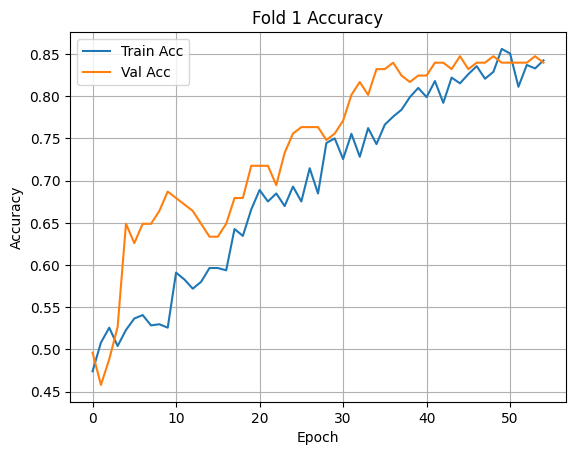

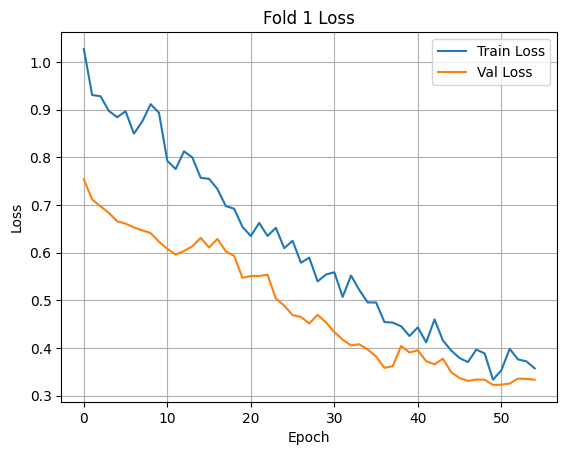

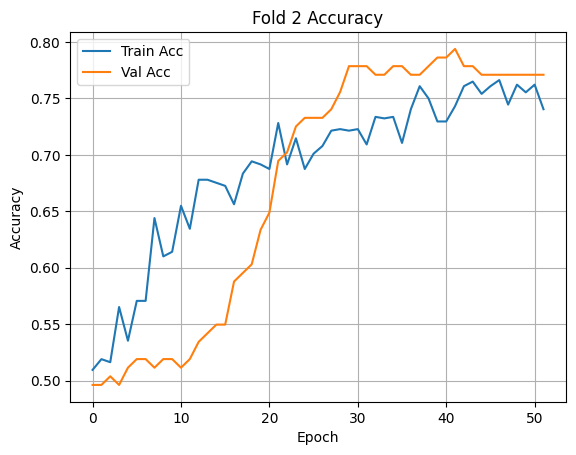

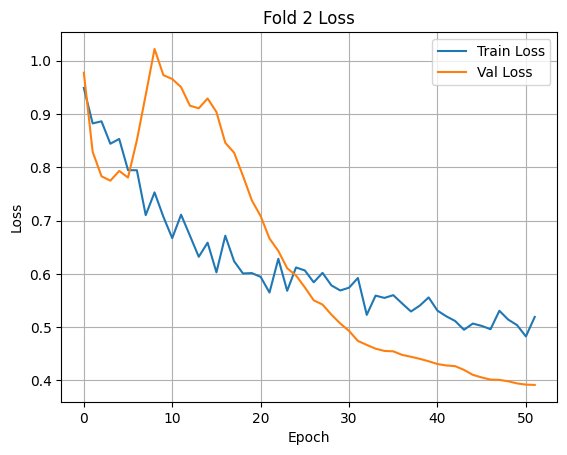

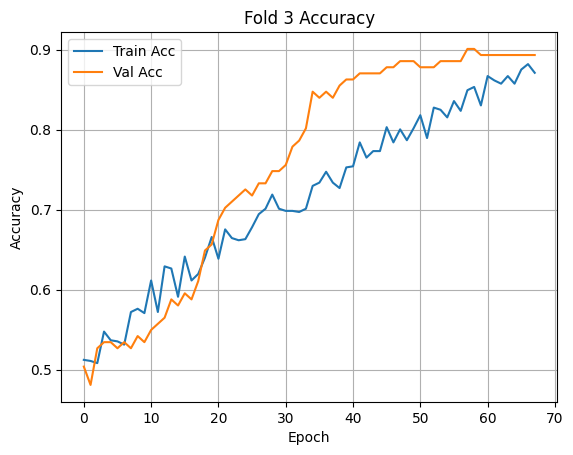

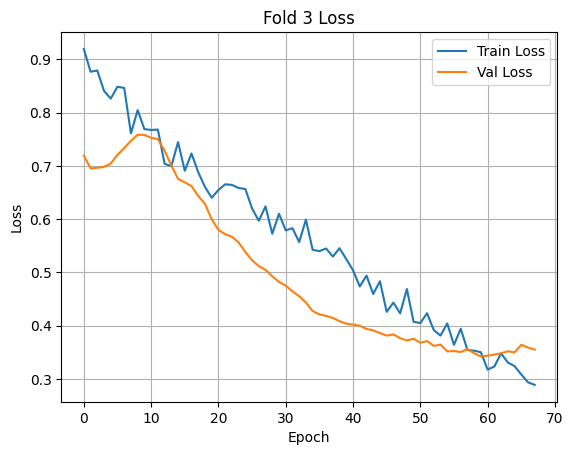

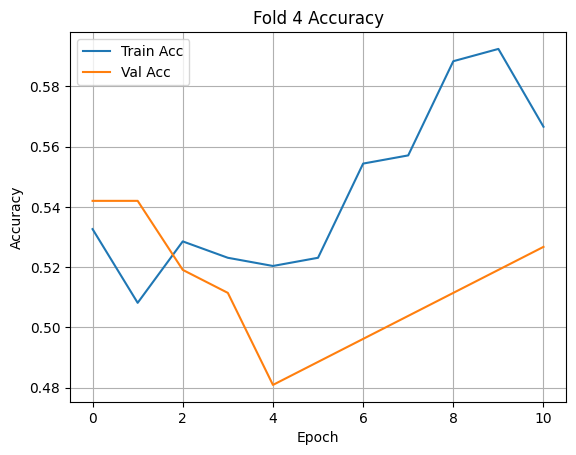

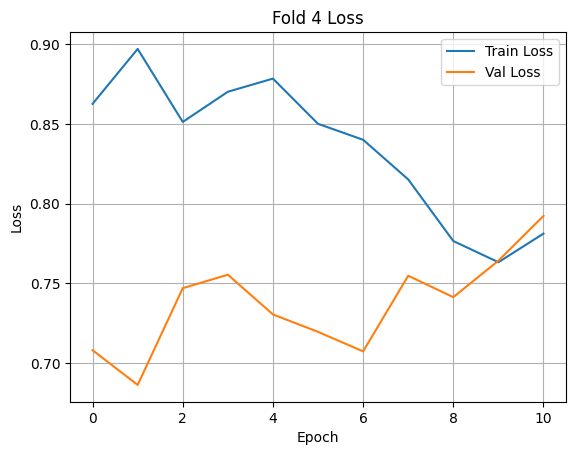

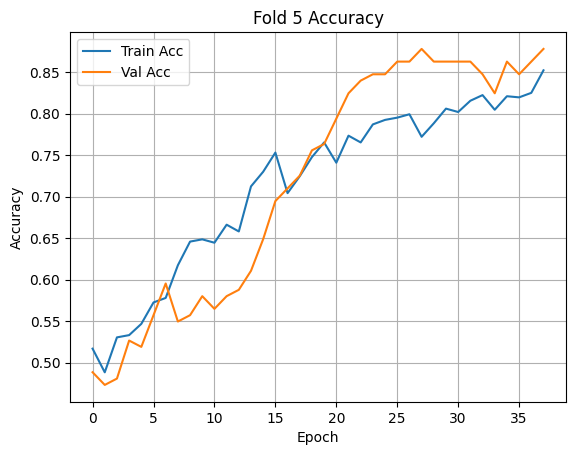

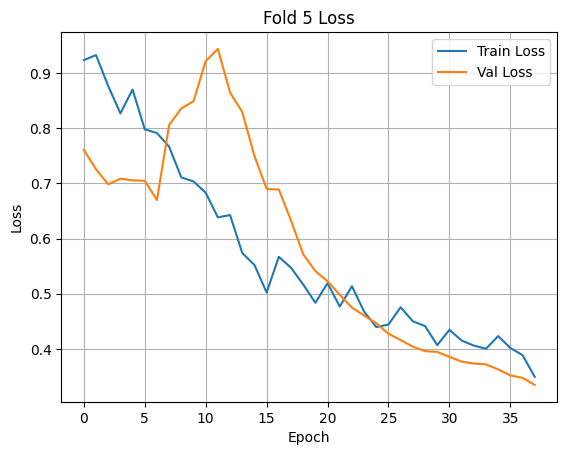

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.825700
precision    0.805169
recall       0.856660
f1           0.829796
auc          0.834114
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.884793,0.848739,0.935185,0.889868,0.943680
1,2,0.976959,0.955752,1.000000,0.977376,0.863660
2,3,0.880184,0.873874,0.889908,0.881818,0.921509
3,4,0.502304,0.504505,0.513761,0.509091,0.534659
4,5,0.884259,0.842975,0.944444,0.890830,0.907064


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.825700
precision    0.805169
recall       0.856660
f1           0.829796
auc          0.834114
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8257
📈 Range Accuracy: 0.4747
📉 Accuracy CV% (std/mean): 22.44%


,fold,accuracy,precision,recall,f1,auc
0,1,0.884793,0.848739,0.935185,0.889868,0.943680
1,2,0.976959,0.955752,1.000000,0.977376,0.863660
2,3,0.880184,0.873874,0.889908,0.881818,0.921509
3,4,0.502304,0.504505,0.513761,0.509091,0.534659
4,5,0.884259,0.842975,0.944444,0.890830,0.907064
